# Dependencies and files

## Install dependencies

## Imports

In [1]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

import time
from tqdm.notebook import tqdm
import requests

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

# Global variables

In [2]:
de_dir_path = '../data/DE/ANOVA_mean/'

In [3]:
layers = ['L1', 'L2', 'L3', 'L4', 'L5', "L6", 'WM']

In [4]:
os.listdir(de_dir_path)

['anova_mamm_mean.csv',
 'cluster_spectr_anova_mean_6.csv',
 'cluster_spectr_anova_mean_7.csv',
 'cluster_spectr_anova_mean_8.csv',
 'cluster_spectr_anova_mean_9.csv',
 'ttest_mamm_mean.csv']

## Load files

### DE results

In [5]:
anova_res = pd.read_csv(de_dir_path + 'anova_mamm_mean.csv', index_col=0)
anova_genes = anova_res[anova_res.p_val_adj < 0.05].index
anova_res.head()

,sum_sq,df,F,PR(>F),p_val_adj
A1BG,0.122578,12.0,2.796490,0.003701,0.010364
AAAS,0.017527,12.0,0.944161,0.509517,0.596369
AACS,0.136394,12.0,2.729393,0.004508,0.012212
AADAT,0.057031,12.0,5.478881,0.000002,0.000016
AAGAB,0.043359,12.0,2.127609,0.026045,0.053640


In [6]:
n_clusters = 7
anova_labels = pd.read_csv(de_dir_path + f'cluster_spectr_anova_mean_{n_clusters}.csv', index_col=0)['0'].sort_values()
anova_labels = anova_labels
anova_labels.name = 'ANOVA_labels'

## Load normalized pseudobulks

In [7]:
pb_dir_path = '../data/pseudobulks/'

In [8]:
os.listdir(pb_dir_path)

['pb_age.h5ad',
 'pb_mammals.h5ad',
 'pb_mammals_filtered.h5ad',
 'pb_mammals_samplenorm_mean.h5ad',
 'pb_mammals_samplenorm_zscore.h5ad']

In [9]:
adata_pb_norm = sc.read_h5ad(pb_dir_path + 'pb_mammals_samplenorm_mean.h5ad')
#adata_pb_norm_mean.var = anova_res
adata_pb_norm

AnnData object with n_obs × n_vars = 89 × 9208
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition', 'lib_size', 'log_lib_size'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props'

In [10]:
background_genes = adata_pb_norm.var_names.tolist()
len(background_genes)

9208

## Specie-specific genes

In [11]:
import pickle
with open("./results/specie_specific_genes_tr77.pkl", "rb") as file:
    genes_dict77 = pickle.load(file)

## Helpful functions

In [12]:
def p_val_group(value):
    if value >= 0.05:
        return 'No significance'
    elif  0.01 <= value < 0.05:
        return 'p < 0.05'
    elif  0.001 <= value < 0.01:
        return 'p < 0.01'
    else:
        return 'p < 0.001'

In [13]:
color_discrete_map = {'No significance': 'darkblue',
                      'p < 0.05': 'purple',
                      'p < 0.01': 'darkorange',
                      'p < 0.001': 'yellow'}

In [14]:
class GeneCluster:
    def __init__(self, genes, descr, label, background_genes, **kwargs):
        self.label = label
        self.genes = genes
        self.descr = descr
        self.background_genes = background_genes
        self.userlist_id = self._get_userlist_id()
        self.background_id = self._get_background_id()
        self.enrichment_res = dict()

    
    def _get_userlist_id(self):
        base_url = "https://maayanlab.cloud/speedrichr"

        description = "sample gene set with background"

        res = requests.post(
            base_url+'/api/addList',
            files=dict(
              list=(None, '\n'.join(self.genes)),
              description=(None, description),
            )
          )
        if res.ok:
            userlist_response = res.json()
        return userlist_response['userListId']
    
    def _get_background_id(self):
        base_url = "https://maayanlab.cloud/speedrichr"

        res = requests.post(
            base_url+'/api/addbackground',
            data=dict(background='\n'.join(self.background_genes))
        )

        if res.ok:
            background_response = res.json()
        return background_response['backgroundid']

    def enrich(self, gene_set_library):
        # get enrichment results
        base_url = "https://maayanlab.cloud/speedrichr"

        res = requests.post(
                base_url+'/api/backgroundenrich',
                data=dict(
                userListId=self.userlist_id,
                backgroundid=self.background_id,
                backgroundType=gene_set_library,
                )
            )
        if res.ok:
            data = res.json()
        # convert results to df
        columns = ['Rank', 'Term', 'p-val', 'Z-score', 'Combined score', 'Overlapping genes', 'Adjusted P-value', 'Old p-value', 'Old adjusted p-value']
        results = pd.DataFrame(data[gene_set_library], columns=columns)
        # preprocess df
        results.Term = results.Term.astype(str)
        results['num_overlap_genes'] = results['Overlapping genes'].apply(lambda x: len(x))
        results['neg_log10(p_adj)'] = - np.log10(results['Adjusted P-value'])
        results['cluster_label'] = self.label
        # save to enrichment_res
        self.enrichment_res[gene_set_library] = results

    @staticmethod
    def enrich_geneclusters(geneclusters, gene_set_library):
        for gc in geneclusters:
            gc.enrich(gene_set_library)

# Clusterisation

In [15]:
df = pd.DataFrame(adata_pb_norm.X, index=adata_pb_norm.obs_names, columns=adata_pb_norm.var_names)

In [16]:
hs_genes = genes_dict77['human']

In [17]:
sample_order = dict()
for cond in ['human', 'chimp', 'macaque']:
    samples = df.loc[df.index.str.contains(cond)].index
    order = sorted(samples.tolist(), key=lambda x: x[-2:])
    order_laminar = list(filter(lambda x: 'L' in x, order))
    order_wm = list(filter(lambda x: 'WM' in x, order))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque']
df = df.loc[sample_order['all']]
df_hs = df[hs_genes]

## Hierarchial

D:\Projects\spatialMPFC\venv\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


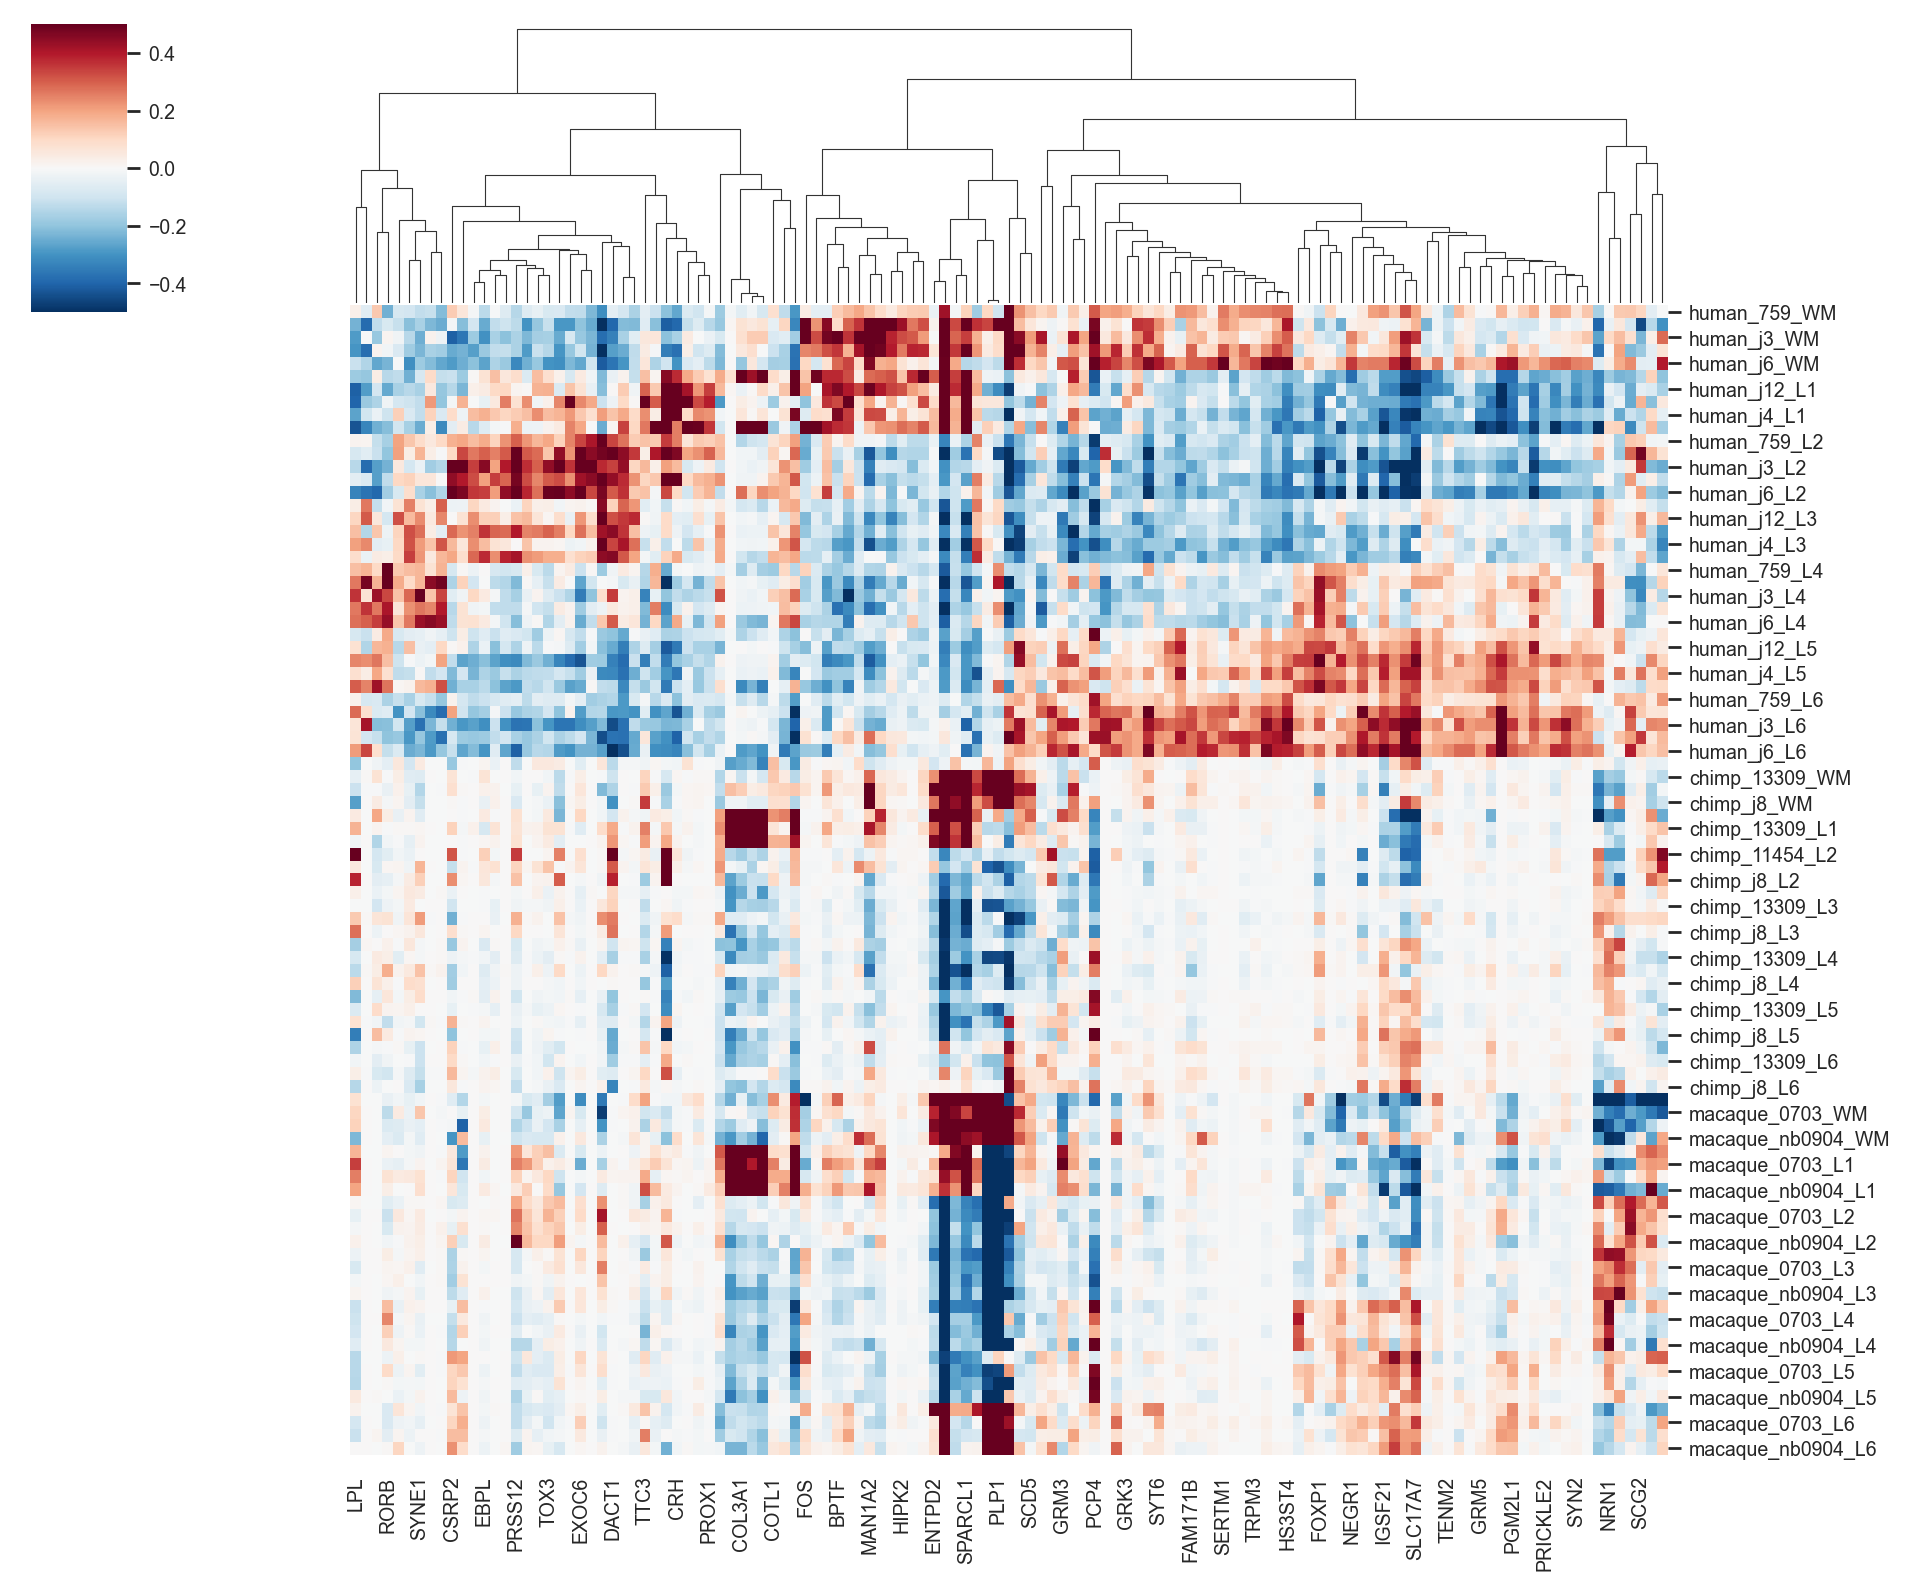

In [18]:
sns.set(font_scale=0.8)
sns.clustermap(df_hs, figsize=(12, 10), cmap="RdBu_r", center=0, vmax=0.5, vmin=-0.5, metric='cosine', annot_kws={"size": 2}, row_cluster=False)

## Spectral clusterisation

In [19]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import pairwise_kernels
aff_matrix = pairwise_kernels(df_hs.loc[sample_order['human']].T, metric='cosine') + 1
n_clusters = 4
clustering = SpectralClustering(n_clusters=n_clusters, gamma=1, affinity='precomputed', random_state=4)
clustering.fit(aff_matrix)

SpectralClustering(affinity='precomputed', gamma=1, n_clusters=4,
                   random_state=4)

In [20]:
labels = pd.Series(clustering.labels_, index=hs_genes).sort_values()
order = labels.sort_values().index

In [21]:
labels.to_csv('./results/human_clusters_77.csv')

<Axes: >

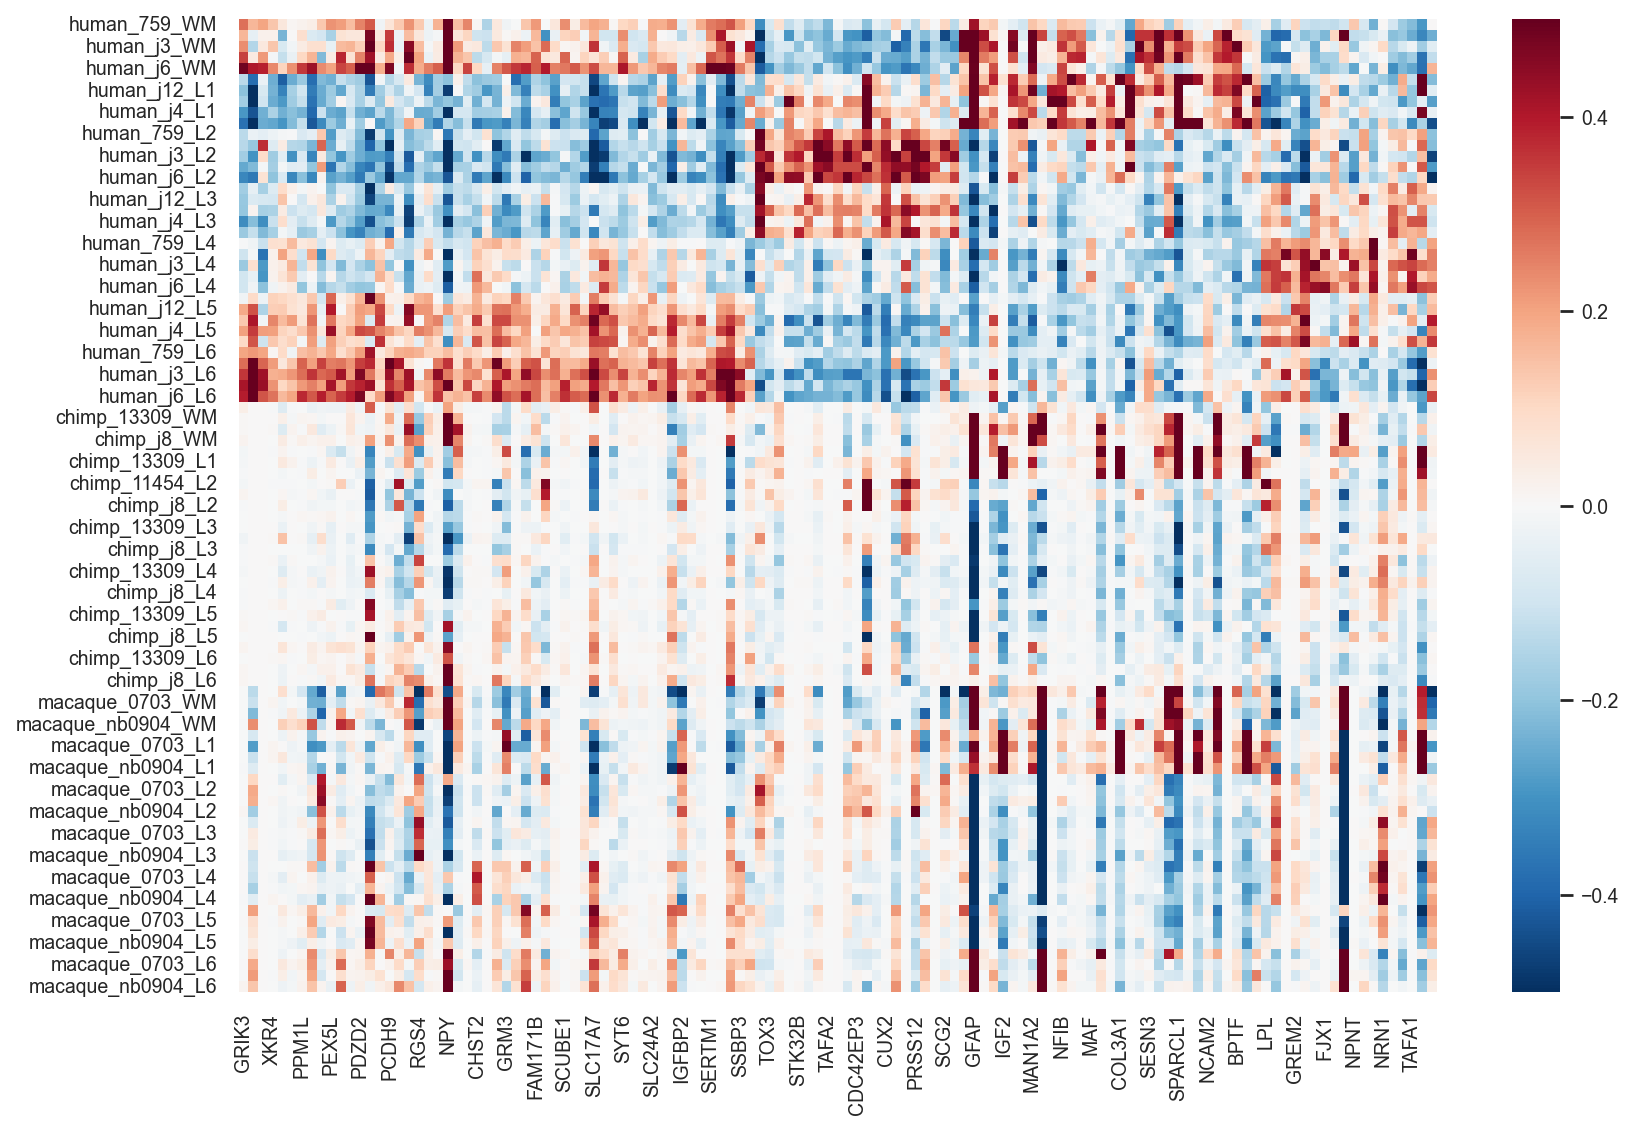

In [22]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df_hs[order], ax=ax, cmap="RdBu_r", vmax=0.5, vmin=-0.5, center=0)

## Cluster profiles

In [23]:
df_annotation = df_hs.copy()
df_annotation['layer'] = adata_pb_norm.obs.layer
df_annotation['condition'] = adata_pb_norm.obs.condition

In [24]:
layer_mean = df_annotation.groupby(['condition', 'layer']).mean()
layer_mean.head()

ACTA2  ADCY1  ADRA2A     ALCAM    B3GAT2     BASP1  \
condition layer                                                          
chimp     L1     0.728220    0.0     0.0  0.009130  0.037836  0.017949   
          L2    -0.127487    0.0     0.0 -0.242804 -0.020487  0.014213   
          L3    -0.095616    0.0     0.0 -0.066325 -0.013114  0.025171   
          L4    -0.111591    0.0     0.0  0.006249 -0.016708 -0.023246   
          L5    -0.077636    0.0     0.0  0.134409  0.000854 -0.015668   

                     BPTF   CAMK2N2       CCK  CDC42EP3  ...     TAFA2  \
condition layer                                          ...             
chimp     L1     0.035123  0.008391  0.120394  0.006277  ... -0.000658   
          L2     0.002007 -0.002283  0.544792  0.003701  ... -0.000658   
          L3    -0.006032  0.000048  0.075539  0.000524  ...  0.001847   
          L4    -0.000353 -0.001080 -0.380507 -0.002334  ... -0.000493   
          L5    -0.017713  0.000563 -0.238573 -0.003733  ... -0.000493   

                    TENM2           TOX      TOX3     TRPM3      TTC3  \
condition layer                                                         
chimp     L1    -0.005502  3.601114e-08  0.054988 -0.007309  0.146501   
          L2     0.003913 -7.797252e-03  0.059883 -0.011230 -0.025527   
          L3     0.003233 -4.682340e-03 -0.014090 -0.011910 -0.097487   
          L4    -0.000745  5.436148e-03 -0.025821  0.007277 -0.118147   
          L5    -0.001334 -1.703686e-03 -0.010624  0.002446 -0.079551   

                    UBAP2      XKR4    ZBTB18    ZBTB20  
condition layer                                          
chimp     L1     0.001697 -0.002482 -0.154330  0.091287  
          L2     0.053347 -0.002482  0.229193  0.002766  
          L3    -0.041216  0.001612  0.178206 -0.039147  
          L4     0.017843 -0.000726  0.129230 -0.062274  
          L5    -0.056467  0.000668  0.023022 -0.055801  

[5 rows x 123 columns]

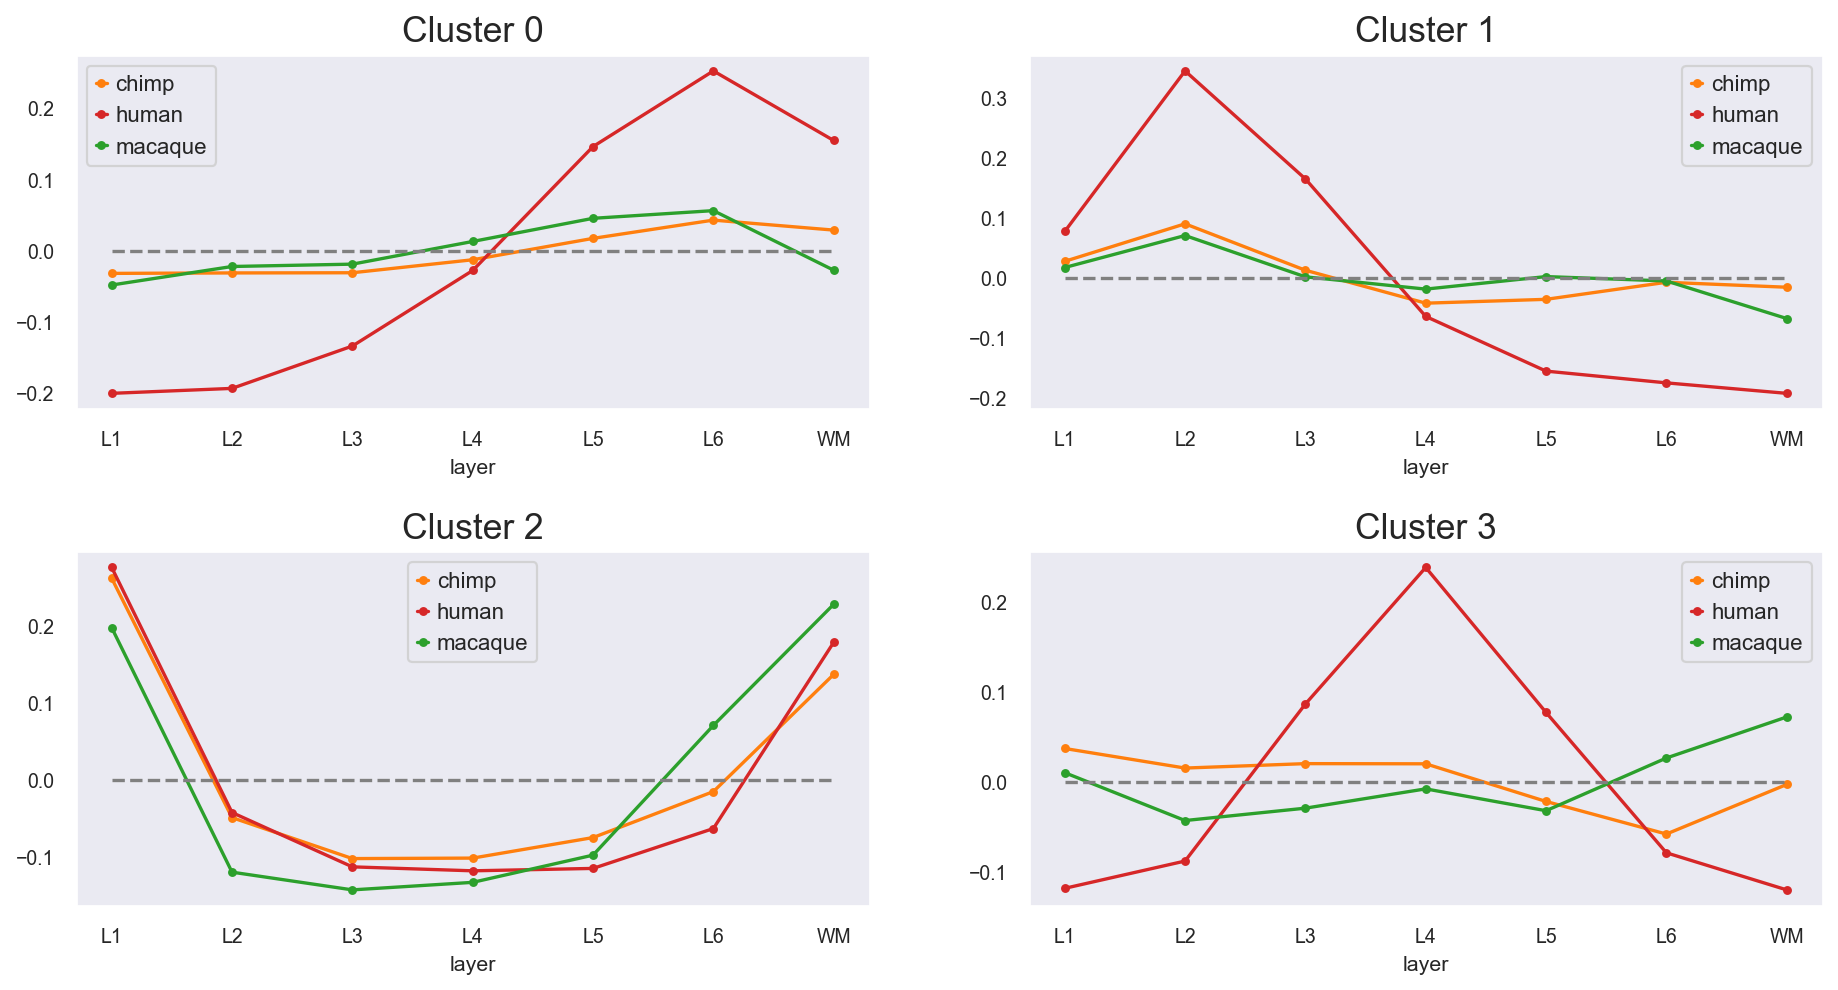

In [25]:
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
sns.set(font_scale=1)
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.tolist()

    (
        layer_mean[genes]
        .mean(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10)
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

# Intersection with ANOVA clusters

In [26]:
anova_hs_inter = hs_genes.intersection(anova_labels.index)
anova_hs_inter

Index(['ACTA2', 'ADCY1', 'ADRA2A', 'ALCAM', 'B3GAT2', 'BASP1', 'BPTF',
       'CAMK2N2', 'CCK', 'CDC42EP3',
       ...
       'TAFA2', 'TENM2', 'TOX', 'TOX3', 'TRPM3', 'TTC3', 'UBAP2', 'XKR4',
       'ZBTB18', 'ZBTB20'],
      dtype='object', length=121)

In [27]:
table_to_pivot = pd.concat([anova_labels.loc[anova_hs_inter], labels.loc[anova_hs_inter]], axis=1)
table_to_pivot.columns = ['ANOVA_labels', 'hs_labels']
pivot_labels_inter = table_to_pivot.groupby('ANOVA_labels').value_counts().unstack().fillna(0)
pivot_labels_inter

hs_labels,0,1,2,3
ANOVA_labels,,,,
0,0.0,21.0,1.0,8.0
1,4.0,0.0,0.0,0.0
2,43.0,0.0,0.0,6.0
3,0.0,0.0,3.0,1.0
4,0.0,0.0,13.0,0.0
5,2.0,0.0,1.0,3.0
6,3.0,0.0,12.0,0.0


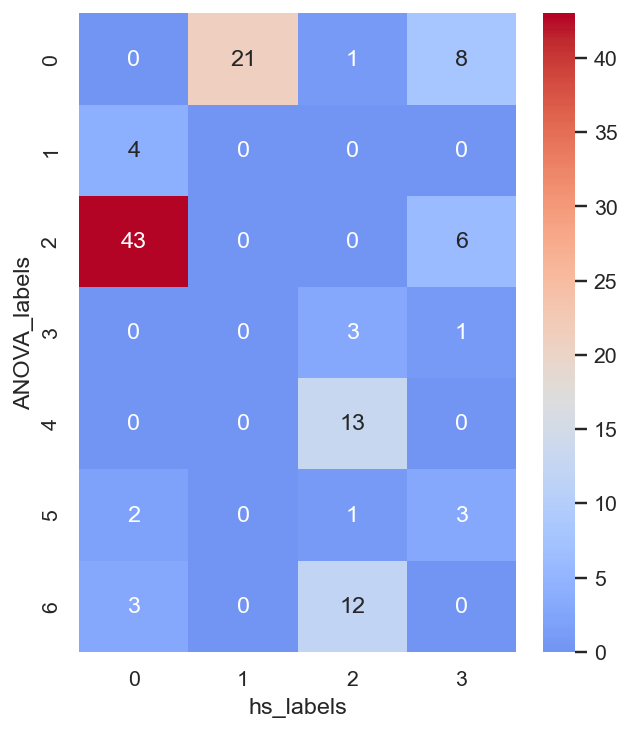

In [28]:
plt.figure(figsize=(5, 6), dpi=70)
sns.set(font_scale=1)
sns.heatmap(pivot_labels_inter, annot=True, cmap = 'coolwarm', fmt=".0f", center=17)
plt.grid(False)

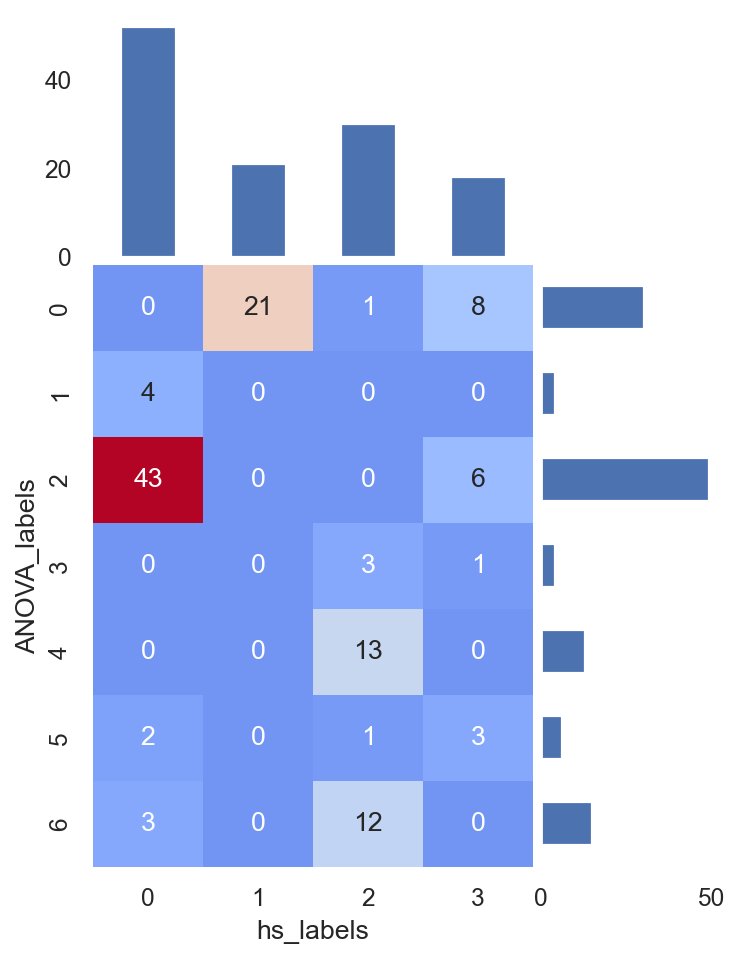

In [29]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(5, 7))
sns.heatmap(pivot_labels_inter, annot=True, cmap = 'coolwarm', center=17, fmt=".0f", ax=ax, cbar=False)


divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='40%', pad=0.05)
pivot_labels_inter.sum(axis=0).plot.bar(ax=cax)
cax.set_facecolor(color='white')
cax.get_xaxis().set_visible(False)

cax = divider.append_axes('right', size='40%', pad=0.05)
index_order = pivot_labels_inter.index[::-1]
pivot_labels_inter.sum(axis=1).loc[index_order].plot.barh(ax=cax)
cax.set_facecolor(color='white')
cax.get_yaxis().set_visible(False)

# Functional analysis

In [30]:
gene_clust = list()
enrich_results = list()

for label in tqdm(sorted(labels.unique())):
    genes = labels[labels == label].index.tolist()
    descr = f'Genes for spectral clustering ({n_clusters} clusters) of human-specific genes. Cluster label: {label}'
    gene_clust.append(GeneCluster(genes, descr, label, background_genes))
    time.sleep(1)

  0%|          | 0/4 [00:00<?, ?it/s]

## GO_Biological_Process_2021

In [31]:
GeneCluster.enrich_geneclusters(gene_clust, 'GO_Biological_Process_2021')

In [32]:
enrich_res = pd.concat([gc.enrichment_res['GO_Biological_Process_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
chemical synaptic transmission (GO:0007268),1,0.000010,8.914711,102.543396,"[GRM3, GRM5, SYT1, NPY, GRIK3, OPRK1, SLC17A7,...",0.004133,0,0,8,2.383727,0
G protein-coupled glutamate receptor signaling pathway (GO:0007216),2,0.000021,78.411429,844.563250,"[GRM3, GRM5, GRIK3]",0.004133,0,0,3,2.383727,0
"regulation of synaptic transmission, glutamatergic (GO:0051966)",3,0.000027,27.597884,289.882741,"[GRM3, GRM5, SYT1, GRIK3]",0.004133,0,0,4,2.383727,0
phospholipase C-activating G protein-coupled receptor signaling pathway (GO:0007200),4,0.000138,36.560000,324.893126,"[GRM5, OPRK1, ADRA2A]",0.013833,0,0,3,1.859081,0
anterograde trans-synaptic signaling (GO:0098916),5,0.000153,8.465895,74.372342,"[GRM3, GRM5, SYT1, NPY, OPRK1, SYN2]",0.013833,0,0,6,1.859081,0


In [33]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

28

In [34]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

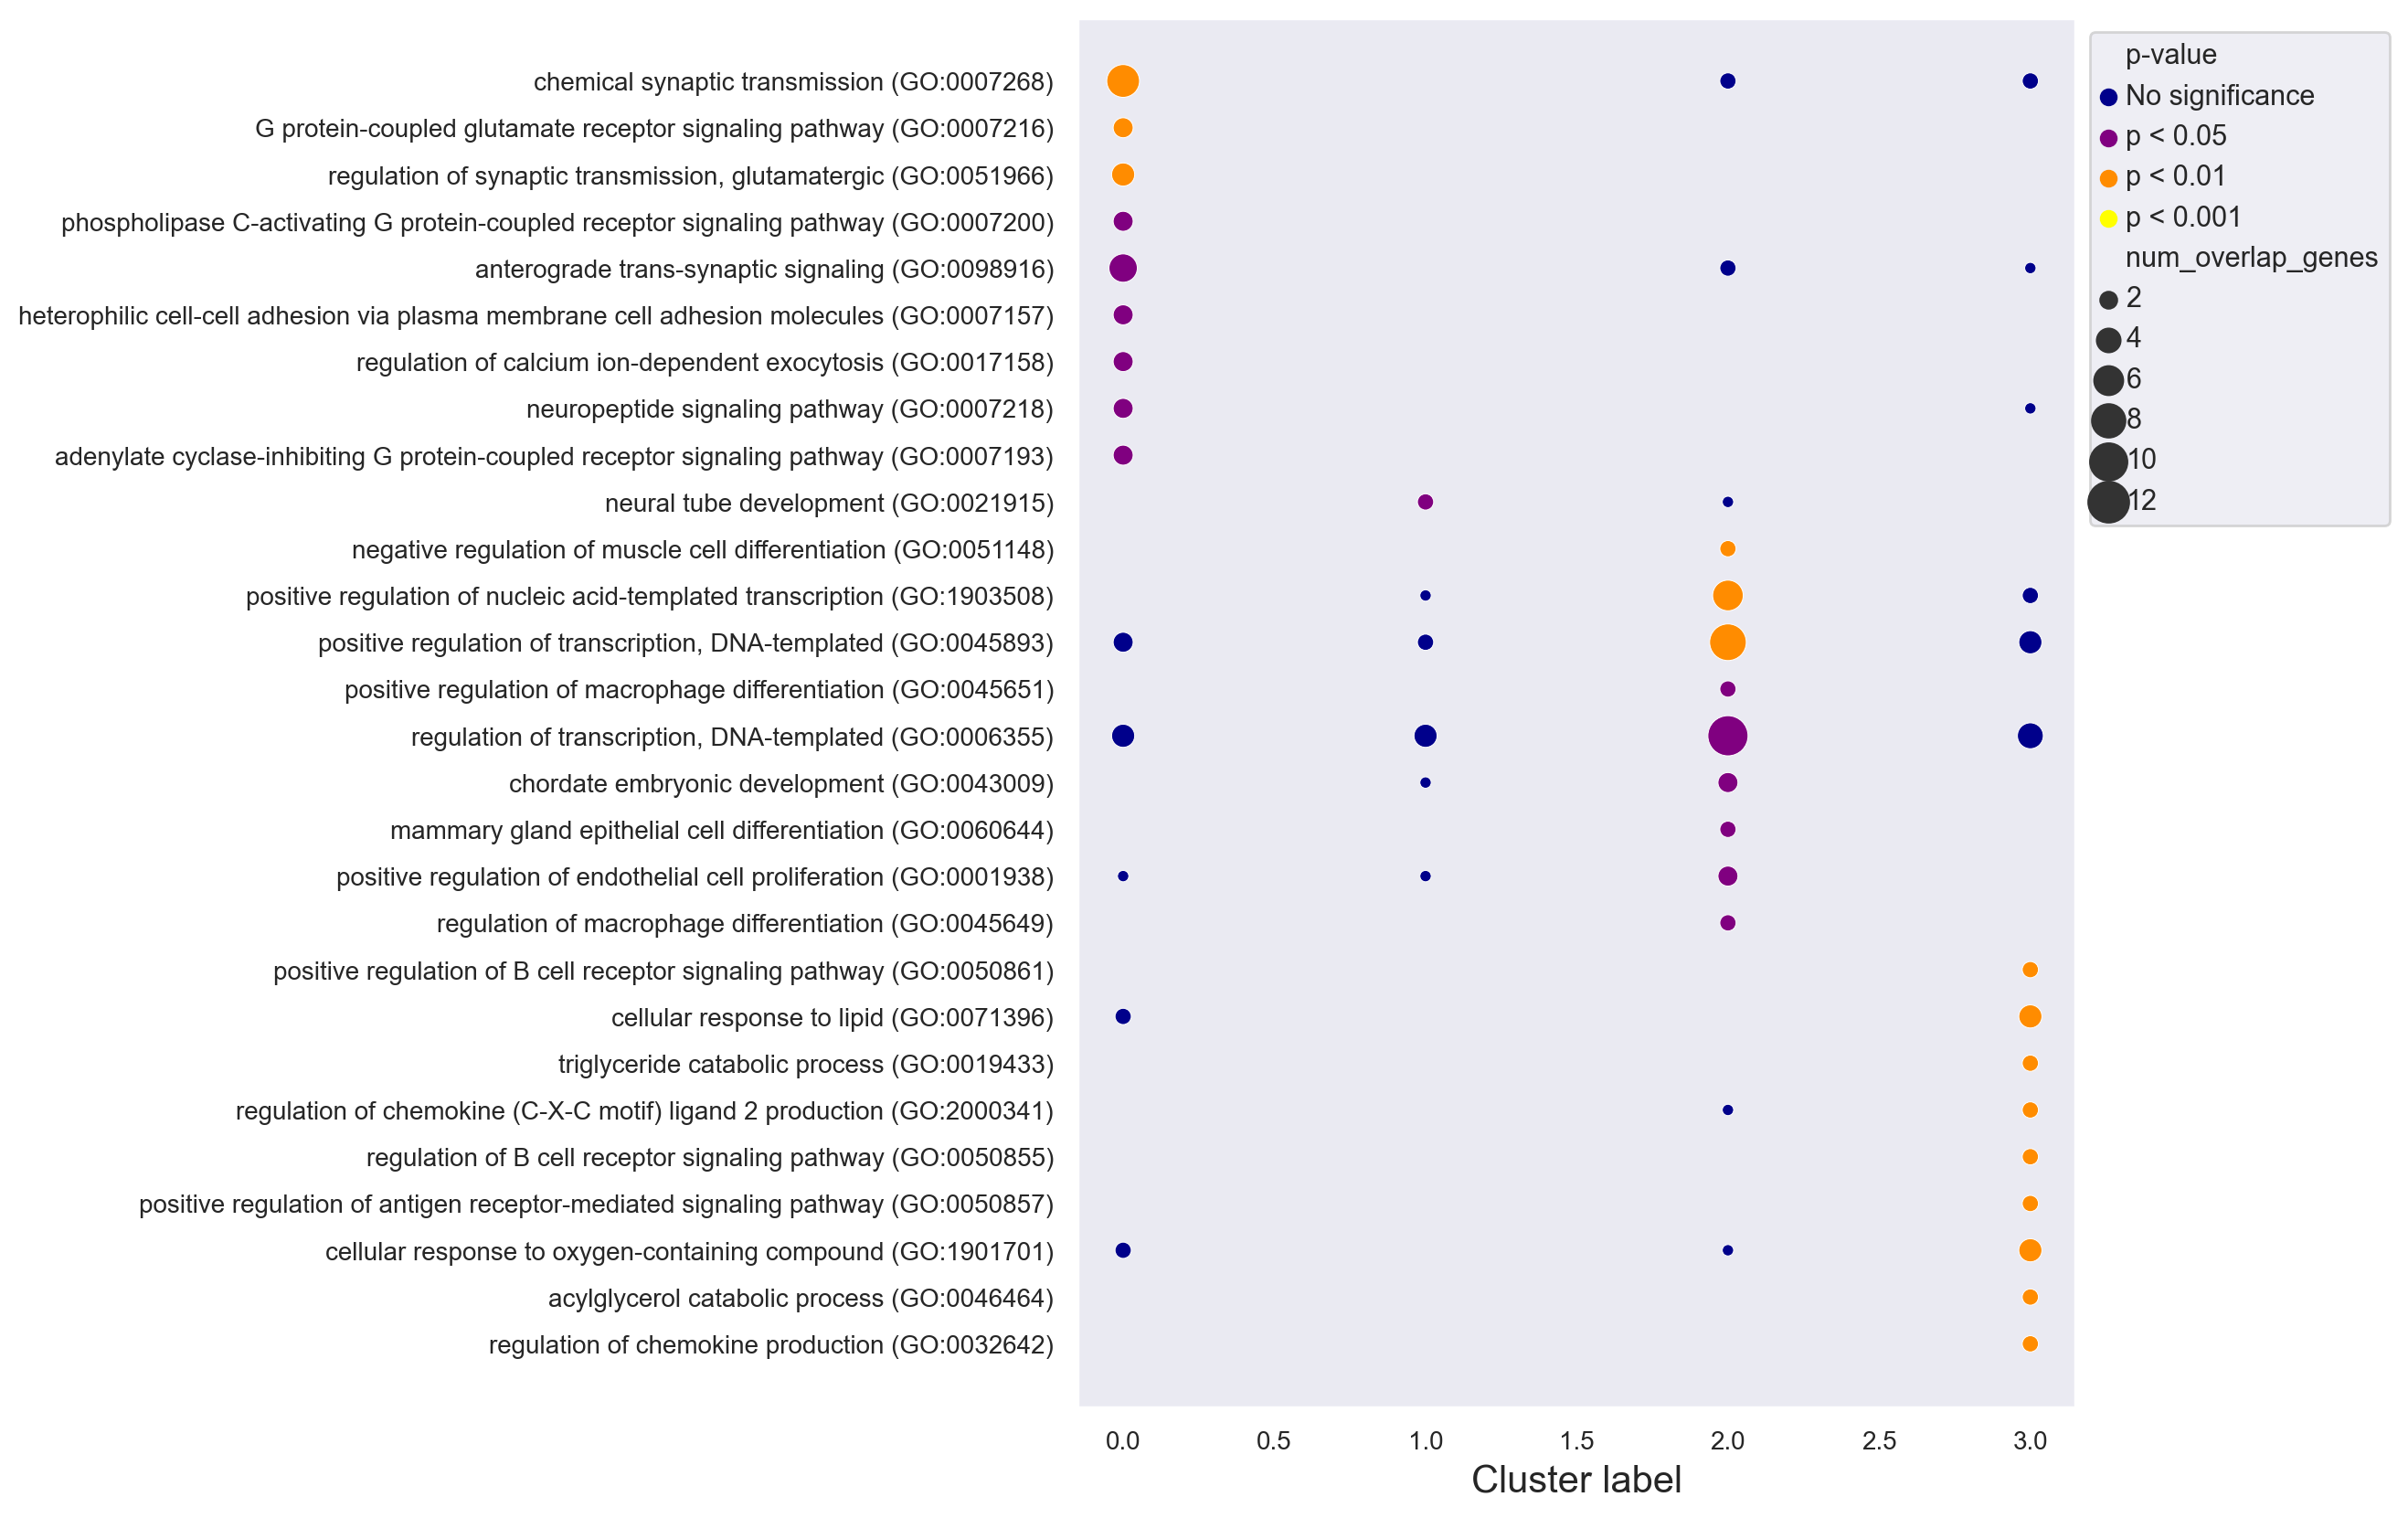

In [35]:
fig = plt.figure(figsize=(7, 10), dpi=100)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Azimuth Cell Types 2021


In [36]:
GeneCluster.enrich_geneclusters(gene_clust, 'Azimuth_Cell_Types_2021')

In [37]:
enrich_res = pd.concat([gc.enrichment_res['Azimuth_Cell_Types_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
"Layer 6 Glutamatergic Neuron, Corticothalamic-Projecting CL0000679",1,0.000006,137.265000,1645.922916,"[TOX, HS3ST4, TRPM3]",0.000341,0,0,3,3.467194,0
LAMP5+ AARD+ Layer 1-6 GABAergic Neuron CL0000617,2,0.000321,119.633987,962.162769,"[CDH13, LRP1B]",0.008808,0,0,2,2.055108,0
"Layer 6 Glutamatergic Neuron, Intratelencephalon-Projecting CL0000679",3,0.000480,89.715686,685.497958,"[CDH13, PTPRK]",0.008808,0,0,2,2.055108,0
Layer 6B Glutamatergic Neuron CL0000679,4,0.000670,71.764706,524.456570,"[HS3ST4, FOXP2]",0.009215,0,0,2,2.035522,0
Vip+ GABAergic Neuron CL0000617,5,0.001140,51.249300,347.285034,"[SYNPR, LRP1B]",0.012544,0,0,2,1.901554,0


In [38]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

34

In [39]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

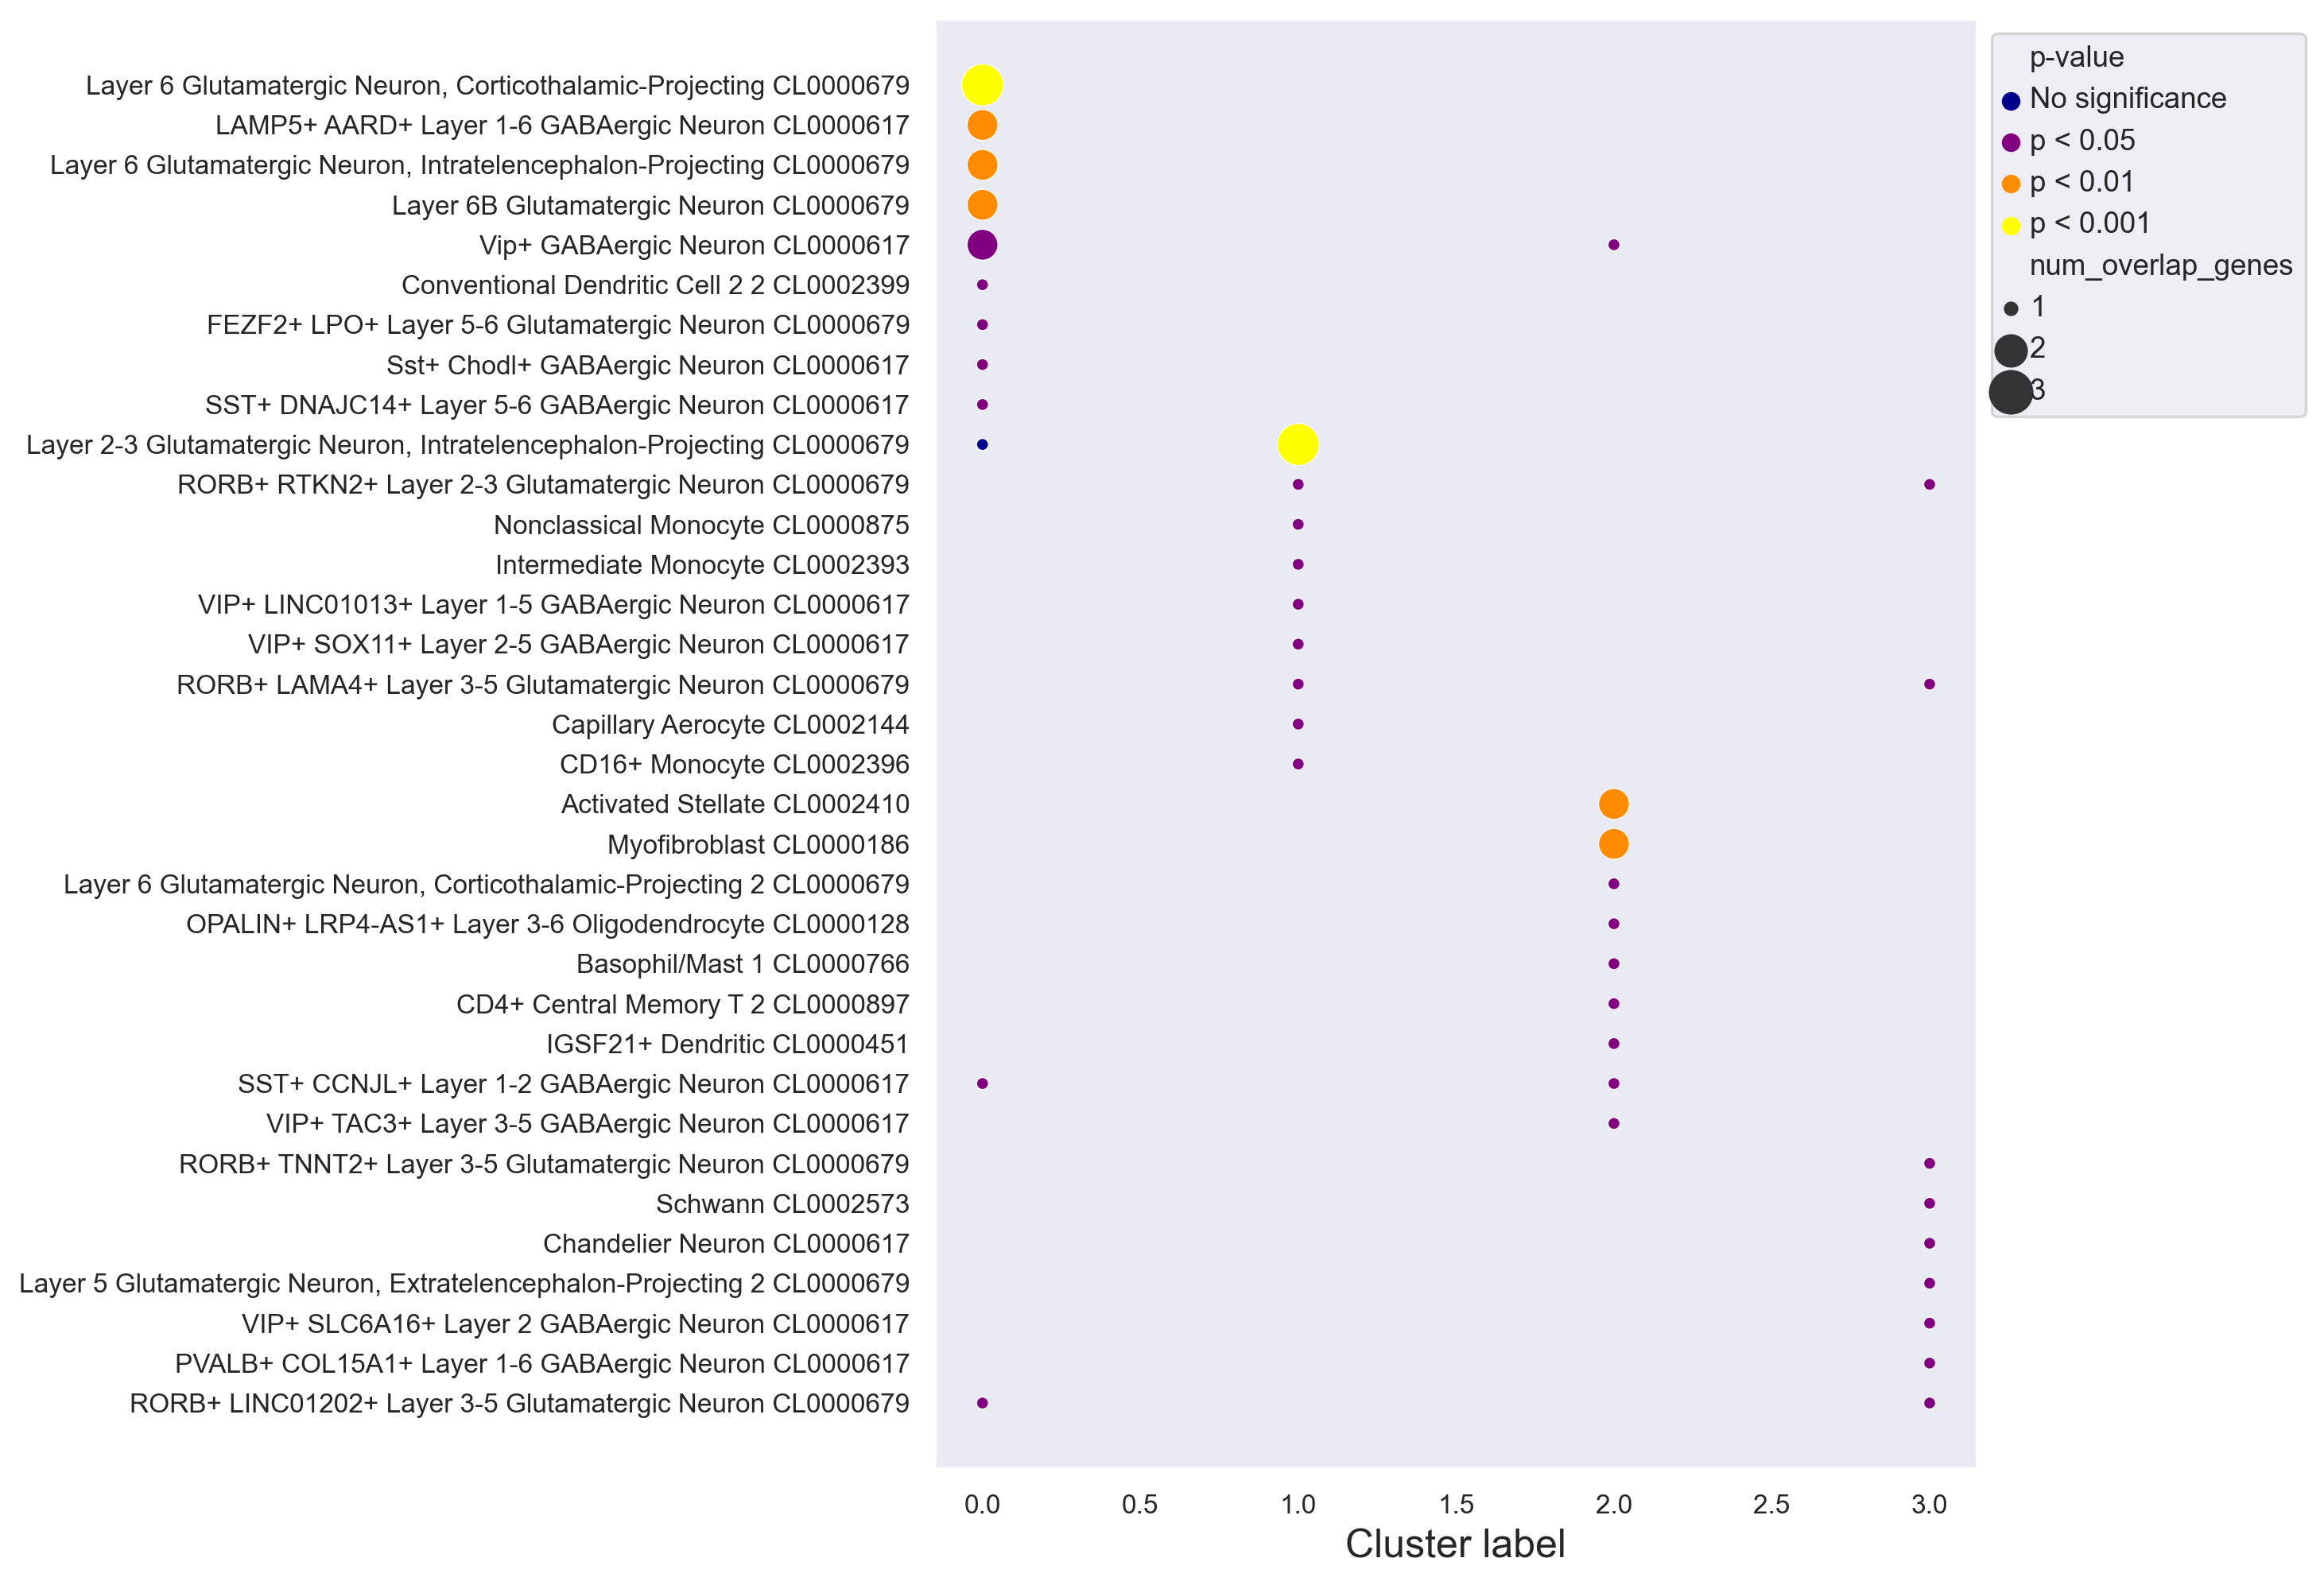

In [40]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## MGI_Mammalian_Phenotype_Level_4_2021

In [41]:
GeneCluster.enrich_geneclusters(gene_clust, 'MGI_Mammalian_Phenotype_Level_4_2021')

In [42]:
enrich_res = pd.concat([gc.enrichment_res['MGI_Mammalian_Phenotype_Level_4_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
abnormal motor learning MP:0002804,1,0.000077,20.678005,195.941412,"[SLC24A2, PEX5L, PCP4, FOXP2]",0.022375,0,0,4,1.650244,0
abnormal CNS synaptic transmission MP:0002206,2,0.000121,11.816406,106.618051,"[SYT1, GRIK3, SLC17A7, ADCY1, SYN2]",0.022375,0,0,5,1.650244,0
impaired behavioral response to morphine MP:0009757,3,0.000194,179.470588,1534.417184,"[RGS4, OPRK1]",0.023943,0,0,2,1.620829,0
abnormal inhibitory learning MP:0020340,4,0.000321,119.633987,962.162769,"[GRM5, SLC17A7]",0.029769,0,0,2,1.526232,0
decreased post-tetanic potentiation MP:0002922,5,0.000480,89.715686,685.497958,"[GRIK3, SYN2]",0.029769,0,0,2,1.526232,0


In [43]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

21

In [44]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

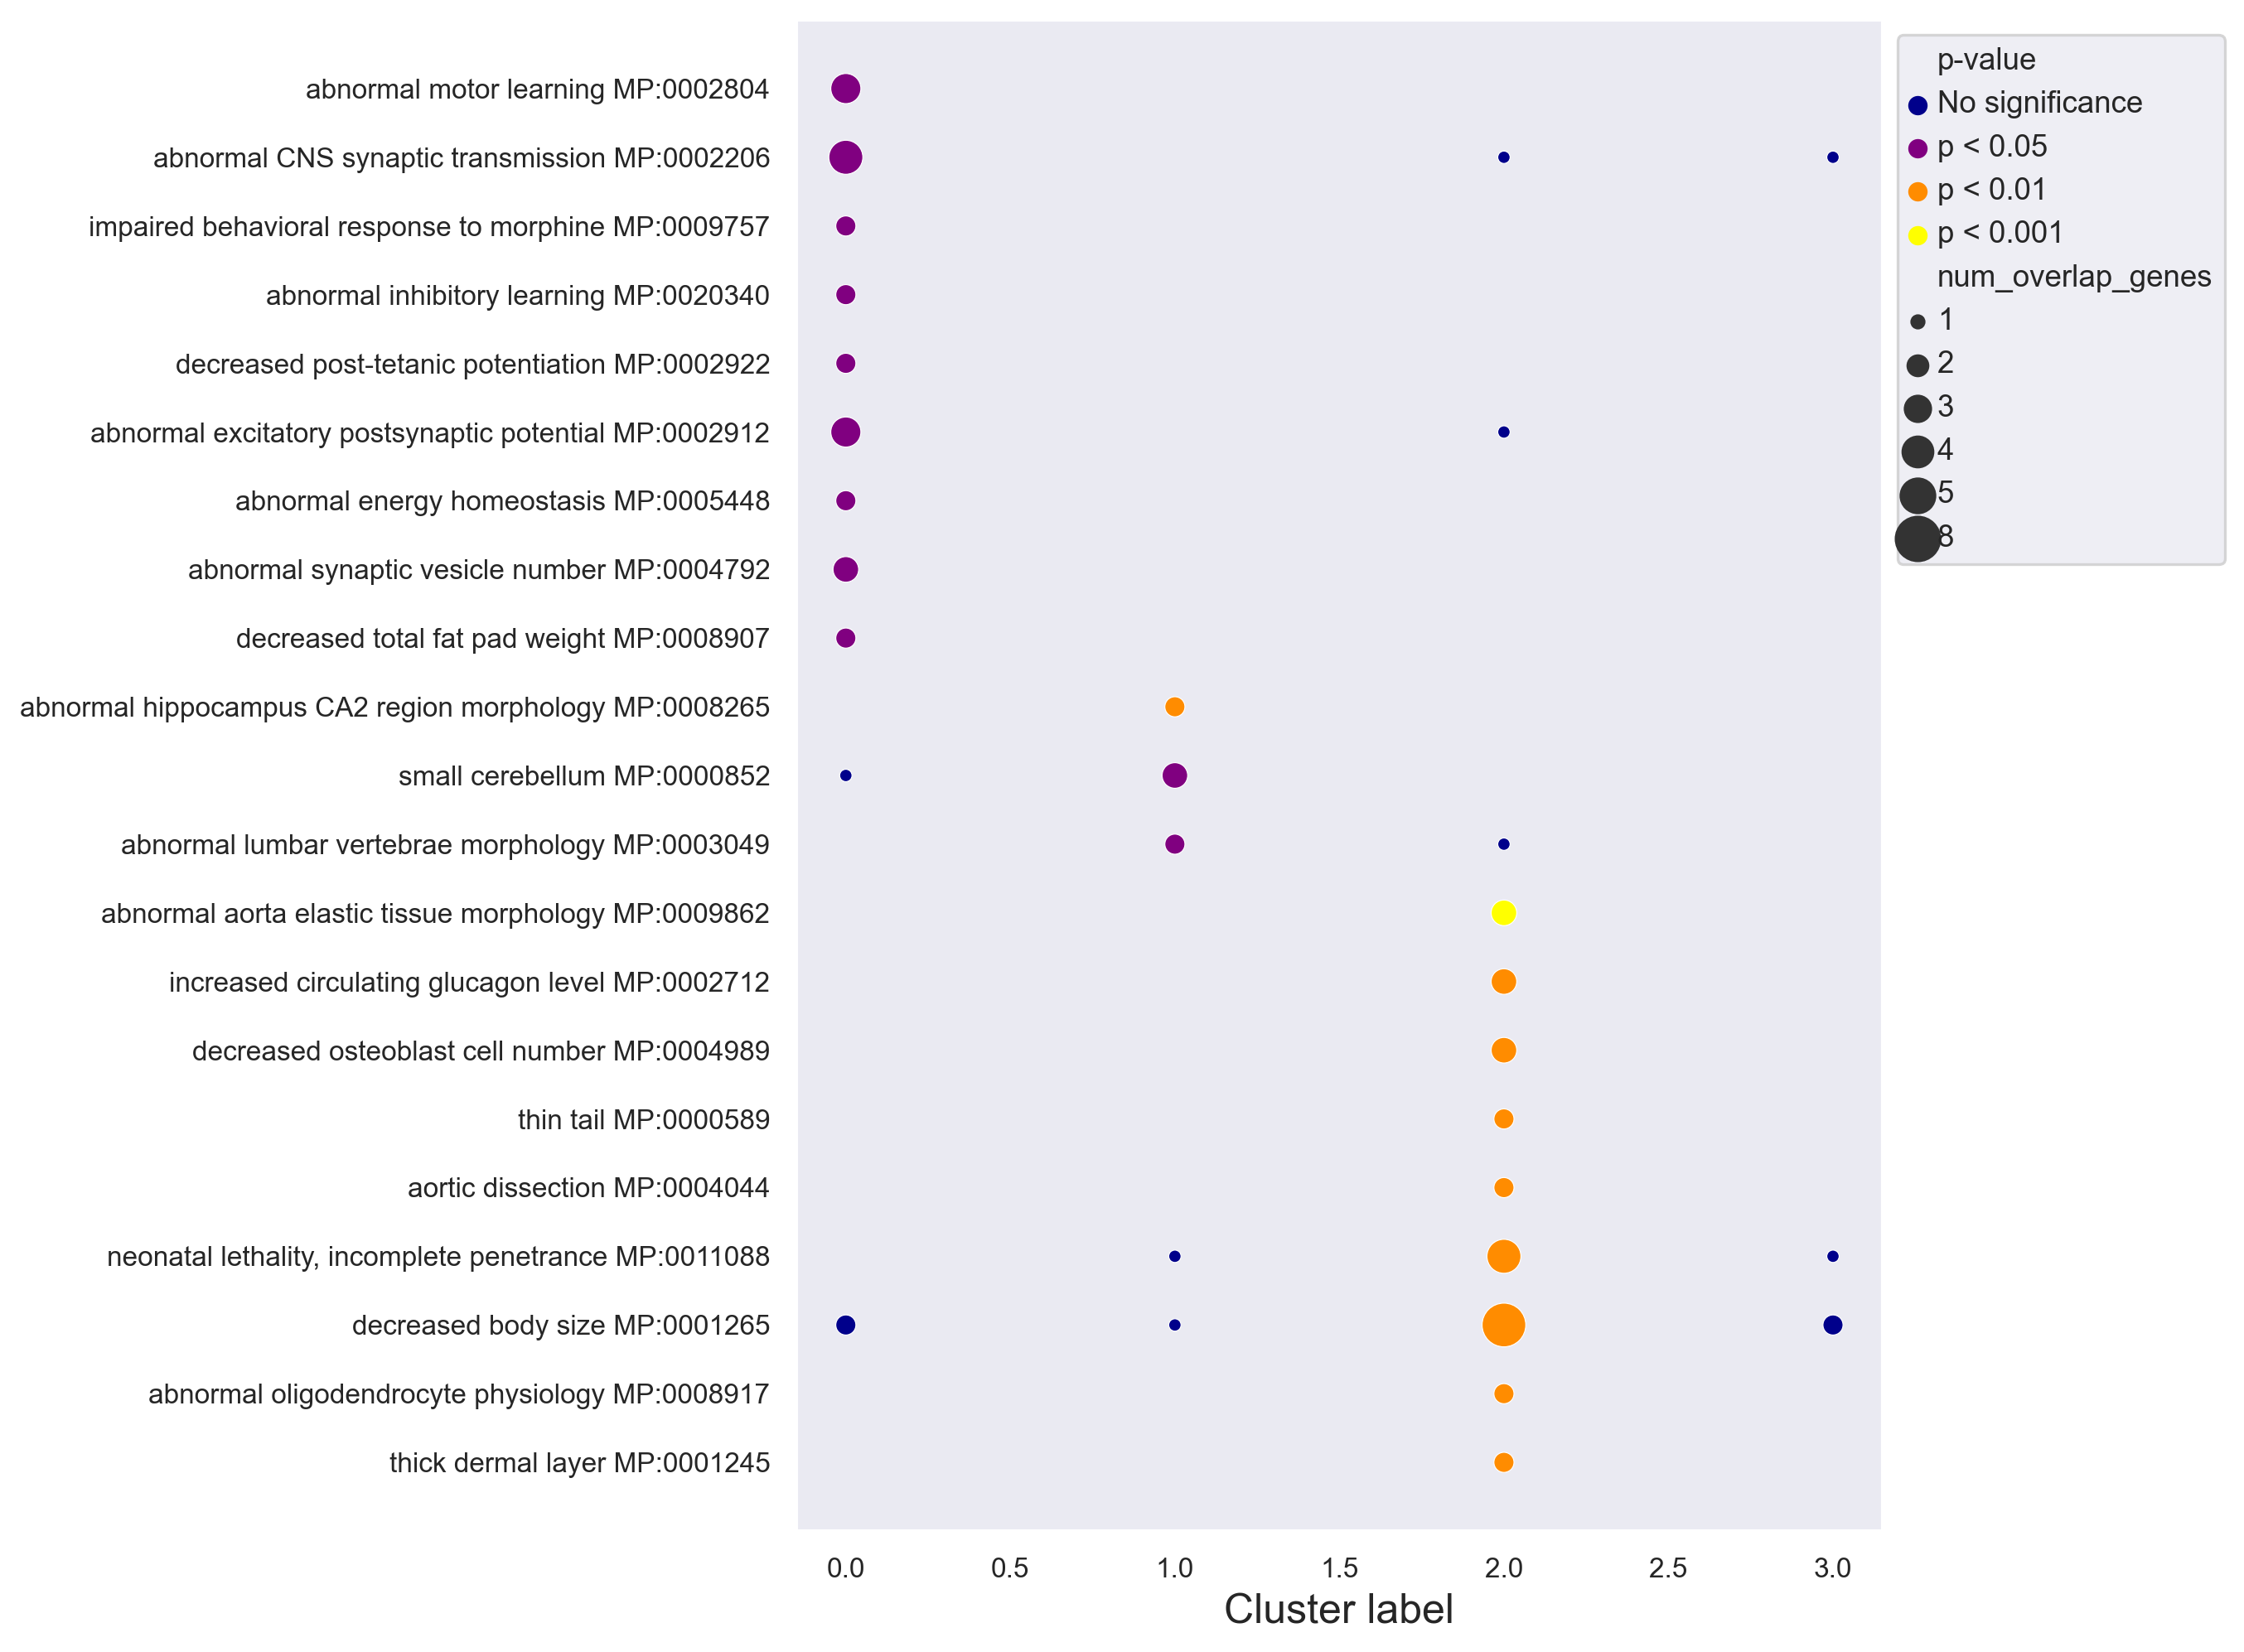

In [45]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Reactome_2022

In [46]:
GeneCluster.enrich_geneclusters(gene_clust, 'Reactome_2022')

In [47]:
enrich_res = pd.concat([gc.enrichment_res['Reactome_2022'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
G Alpha (I) Signaling Events R-HSA-418594,1,0.000004,12.747383,159.150125,"[GRM3, RGS4, NPY, OPRK1, ADCY1, SSTR2, ADRA2A]",0.000312,0,0,7,3.505414,0
GPCR Downstream Signaling R-HSA-388396,2,0.000004,8.545986,105.645249,"[GRM3, RGS4, GRK3, GRM5, NPY, OPRK1, ADCY1, SS...",0.000312,0,0,9,3.505414,0
Signaling By GPCR R-HSA-372790,3,0.000008,7.832423,91.607887,"[GRM3, RGS4, GRK3, GRM5, NPY, OPRK1, ADCY1, SS...",0.000405,0,0,9,3.392269,0
GPCR Ligand Binding R-HSA-500792,4,0.000012,13.785714,156.552233,"[GRM3, GRM5, NPY, OPRK1, SSTR2, ADRA2A]",0.000427,0,0,6,3.369608,0
Class A/1 (Rhodopsin-like Receptors) R-HSA-373076,5,0.000288,14.290424,116.507320,"[NPY, OPRK1, SSTR2, ADRA2A]",0.008407,0,0,4,2.075344,0


In [48]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

16

In [49]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

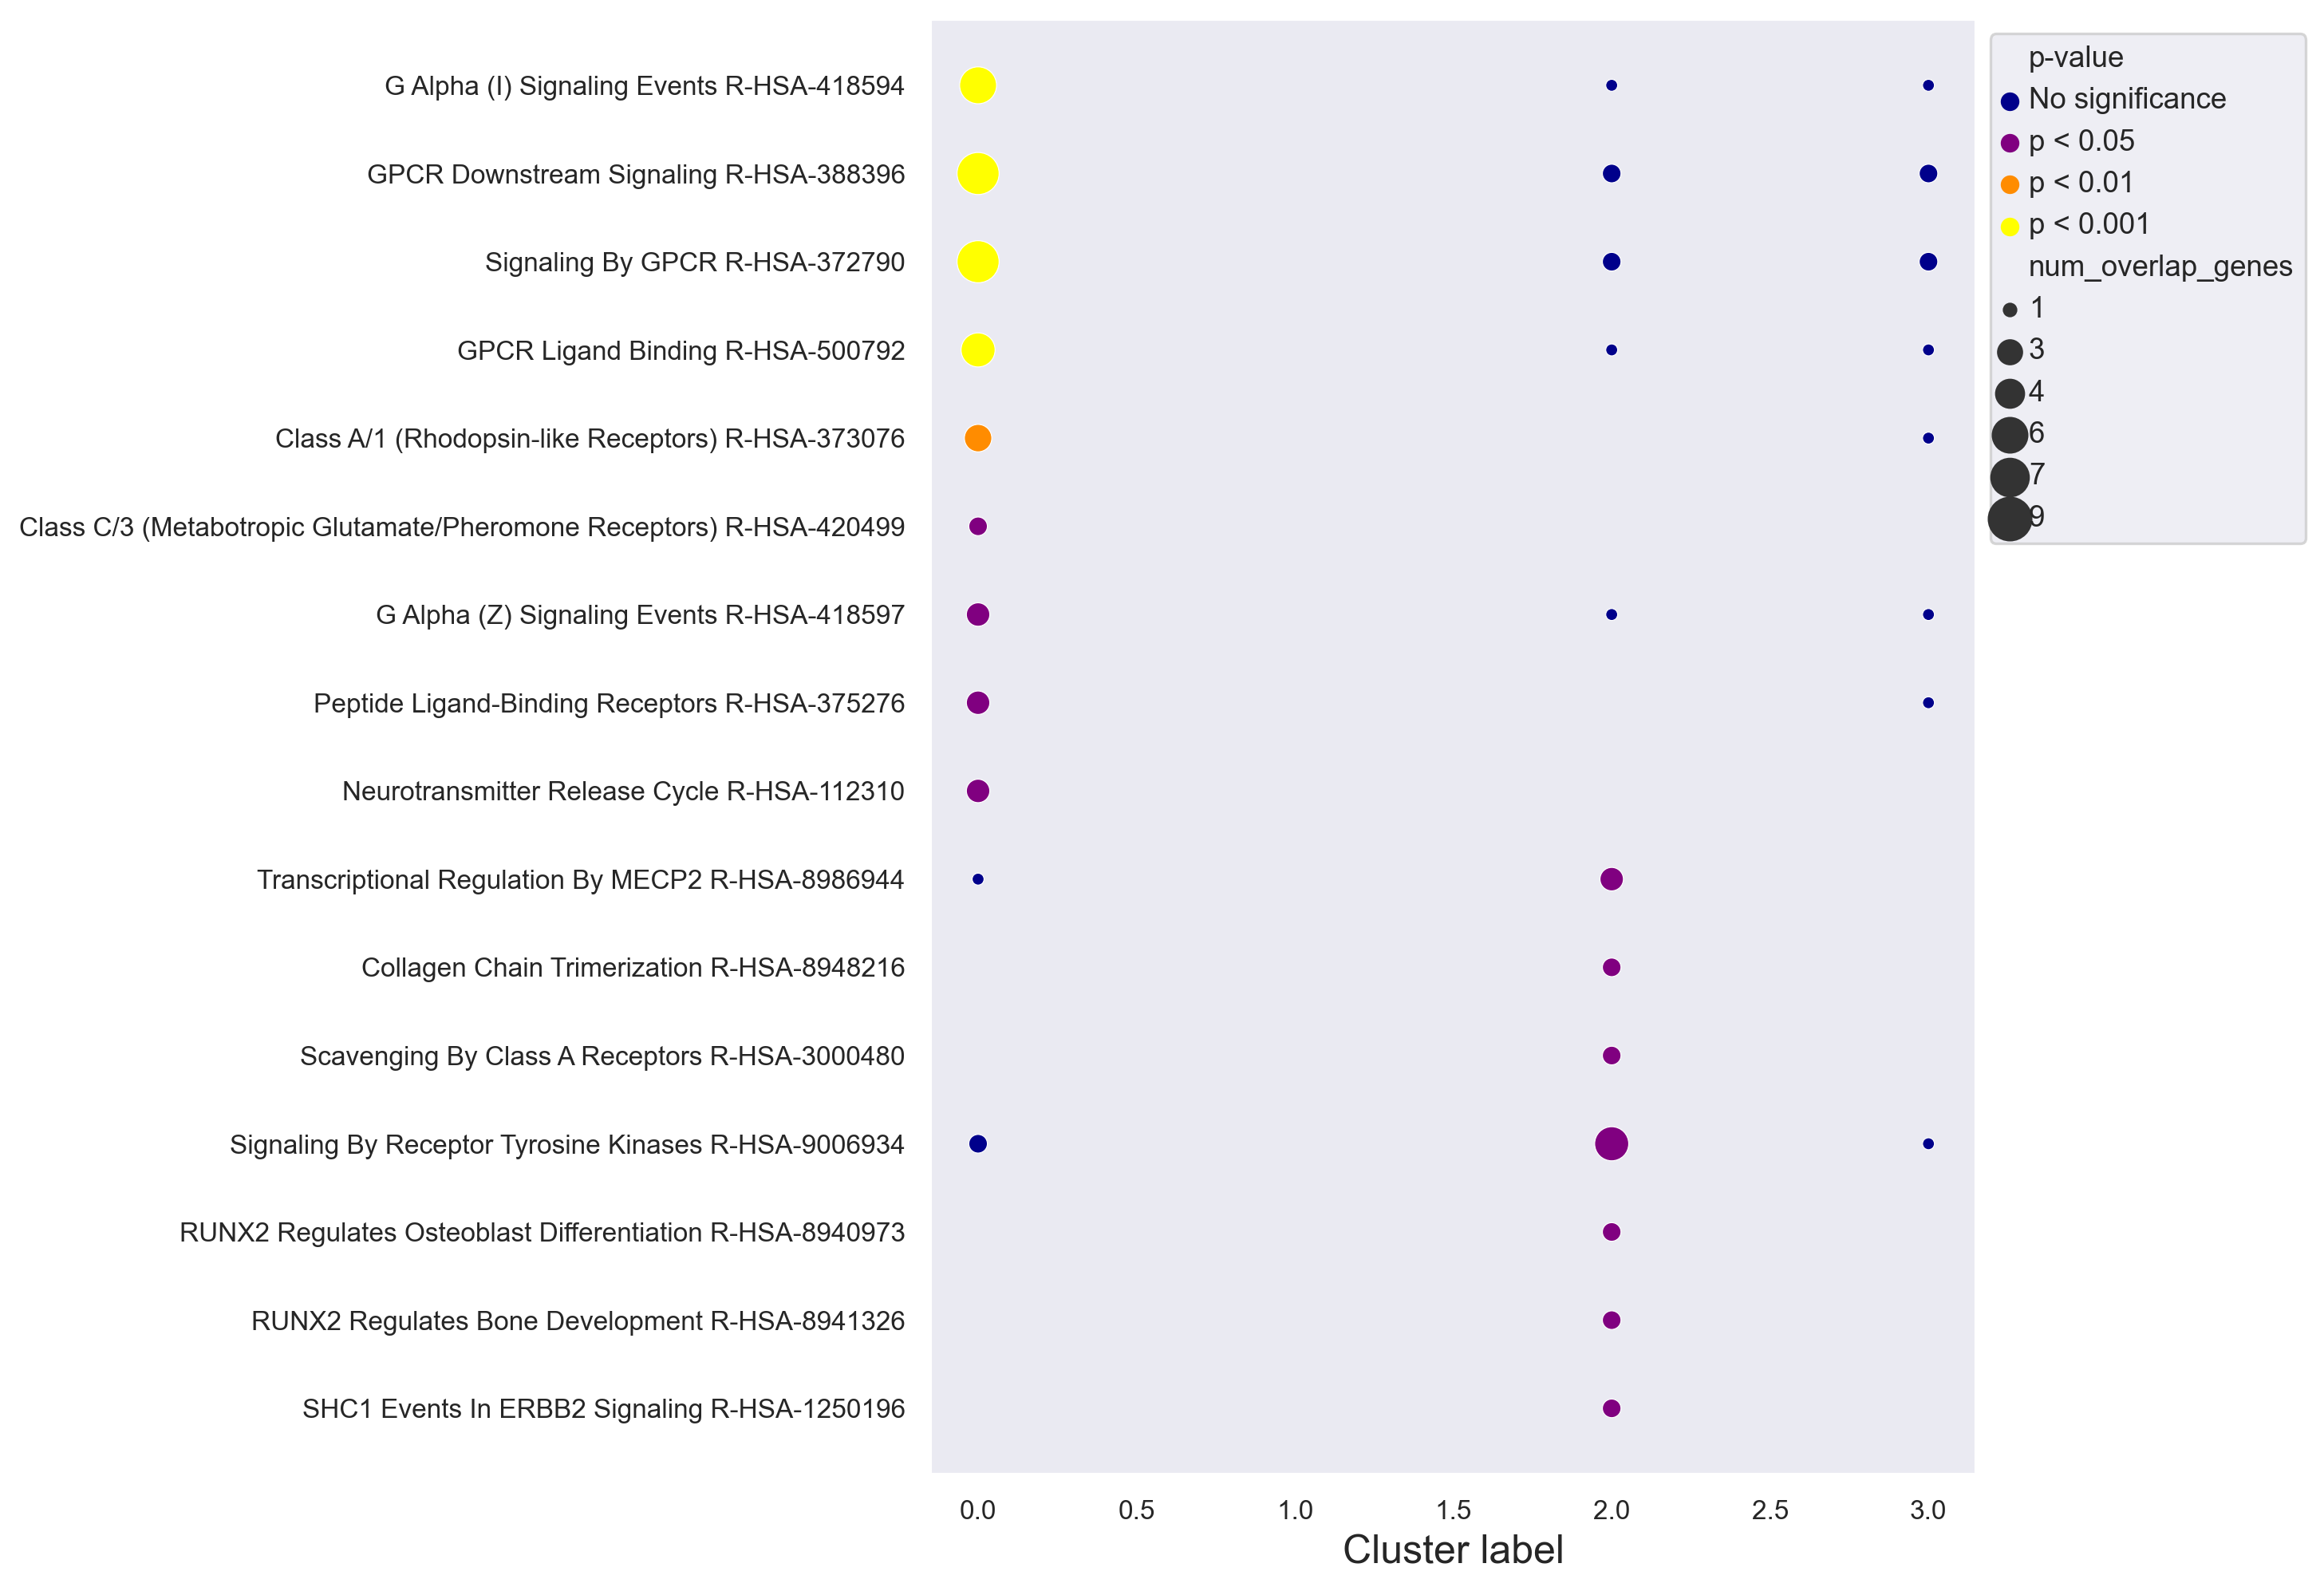

In [50]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## KEGG_2021_Human

In [51]:
GeneCluster.enrich_geneclusters(gene_clust, 'KEGG_2021_Human')

In [52]:
enrich_res = pd.concat([gc.enrichment_res['KEGG_2021_Human'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
Neuroactive ligand-receptor interaction,1,6.669531e-07,16.837487,239.438256,"[GRM3, GRM5, NPY, GRIK3, OPRK1, SSTR2, ADRA2A]",0.000049,0,0,7,4.312582,0
Glutamatergic synapse,2,8.399203e-06,14.666308,171.410617,"[GRM3, GRK3, GRM5, GRIK3, SLC17A7, ADCY1]",0.000307,0,0,6,3.513469,0
Phospholipase D signaling pathway,3,1.956552e-03,8.315524,51.860358,"[GRM3, DNM3, GRM5, ADCY1]",0.047609,0,0,4,1.322307,0
Synaptic vesicle cycle,4,2.915985e-03,11.627234,67.874531,"[DNM3, SYT1, SLC17A7]",0.053217,0,0,3,1.273952,0
Regulation of lipolysis in adipocytes,5,1.621221e-02,11.180147,46.084464,"[NPY, ADCY1]",0.219897,0,0,2,0.657781,0


In [53]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

7

In [54]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

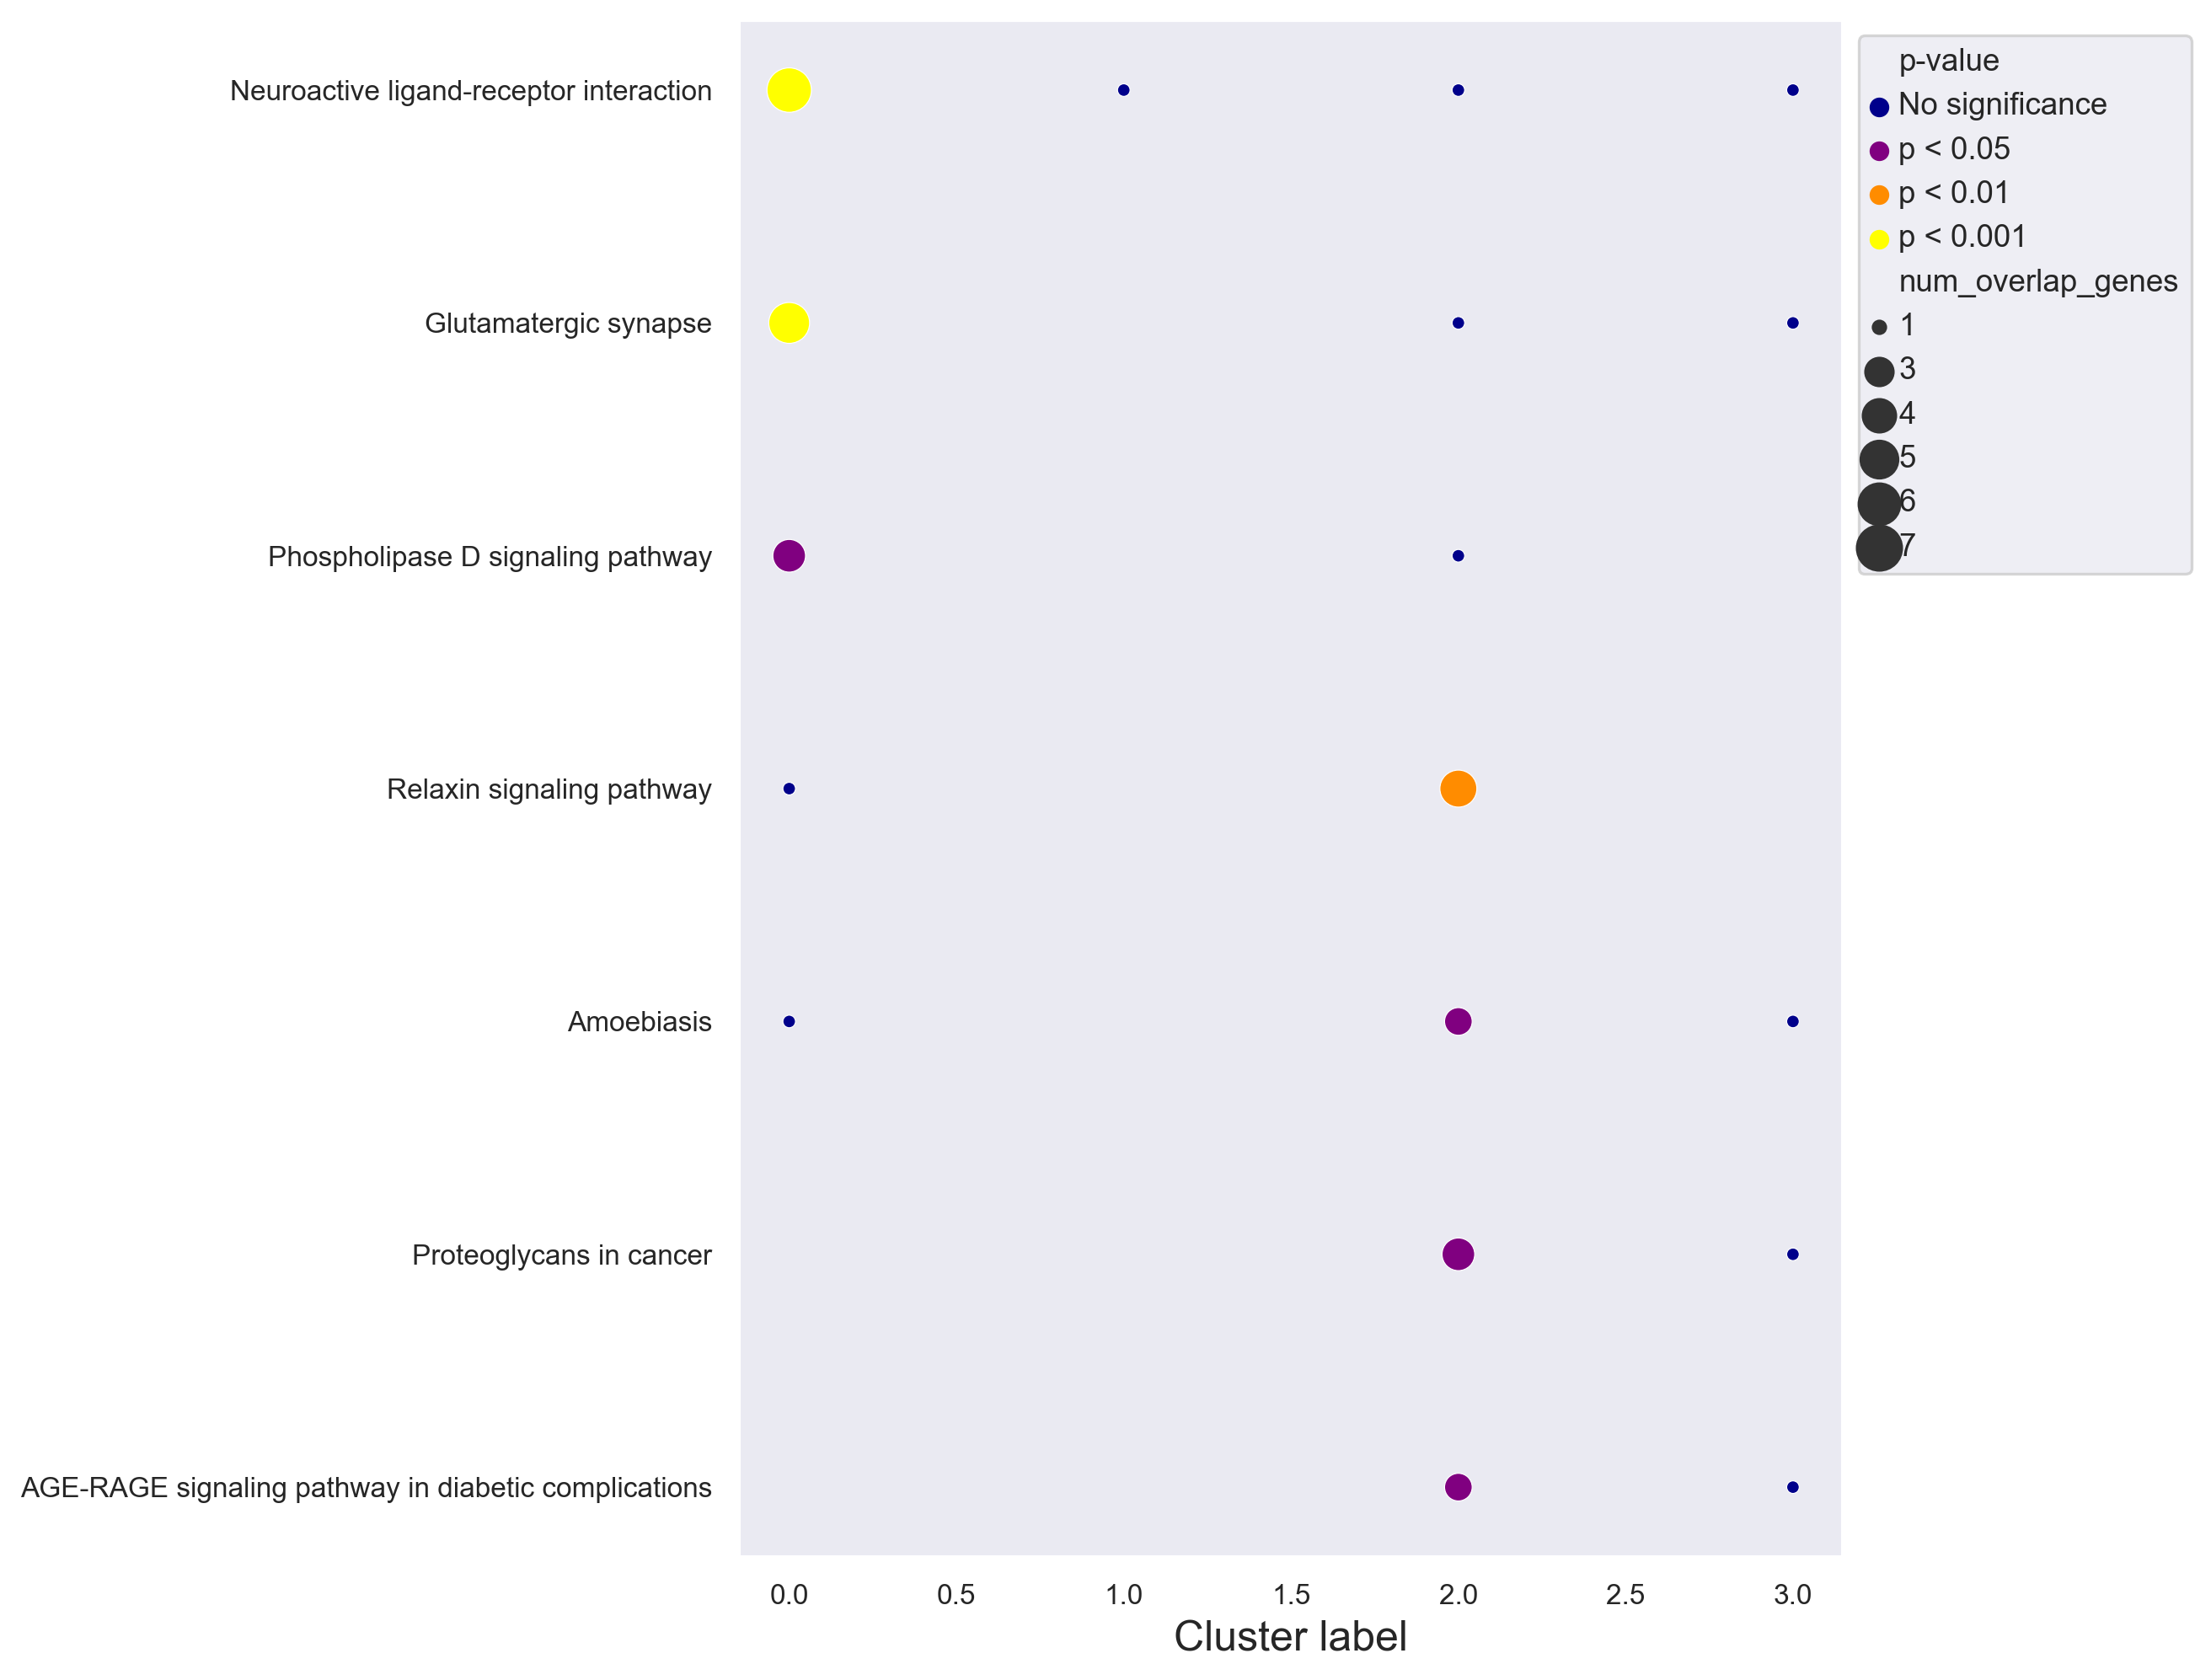

In [55]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))